In [6]:
!pip install geopandas -q

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import seaborn as sns
import geopandas as gpd

np.random.seed(100)

Part 2 . Part 2 ●• Explore Survey Data

In [8]:
kenya_survey = pd.read_csv('kenya_survey.csv')
nigeria_survey = pd.read_csv('nigeria_survey.csv')

Question 2.1 ●• Kenya Surveys Count

In [9]:
kenya_households = len(kenya_survey)
print(f"●• Total household surveys in Kenya --> {kenya_households:,}")

●• Total household surveys in Kenya --> 36,224


Question 2.2 ●• Nigeria Surveys Count

In [10]:
nigeria_households = len(nigeria_survey)
print(f"●• Total household surveys in Nigeria --> {nigeria_households:,}")

●• Total household surveys in Nigeria --> 40,220


Question 2.3 ●• Kenya Clusters Count

In [11]:
kenya_clusters = kenya_survey['cluster'].nunique()
print(f"●• Unique clusters in Kenya --> {kenya_clusters}")

●• Unique clusters in Kenya --> 1585


Question 2.4 ●• Nigeria Clusters Count

In [12]:
nigeria_clusters = nigeria_survey['cluster'].nunique()
print(f"●• Unique clusters in Nigeria --> {nigeria_clusters}")

●• Unique clusters in Nigeria --> 1382


Question 2.5 ●• Cluster Maps

In [13]:
kenya_cluster_data = kenya_survey.groupby(['cluster', 'rural']).agg({
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

nigeria_cluster_data = nigeria_survey.groupby(['cluster', 'rural']).agg({
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

In [14]:
def create_cluster_maps():
    world = gpd.read_file('world-administrative-boundaries.geojson')

    kenya_shape = world[world['name'] == 'Kenya']
    nigeria_shape = world[world['name'] == 'Nigeria']


    kenya_gdf = gpd.GeoDataFrame(
        kenya_cluster_data,
        geometry=gpd.points_from_xy(
            kenya_cluster_data.longitude, kenya_cluster_data.latitude),
        crs="EPSG:4326"
    )

    nigeria_gdf = gpd.GeoDataFrame(
        nigeria_cluster_data,
        geometry=gpd.points_from_xy(
            nigeria_cluster_data.longitude, nigeria_cluster_data.latitude),
        crs="EPSG:4326"
    )

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))


    kenya_shape.boundary.plot(ax=axes[0], linewidth=2, color='black')
    kenya_gdf[kenya_gdf['rural'] == 0].plot(
        ax=axes[0],
        color='crimson',
        markersize=30,
        alpha=0.7,
        label='Urban'
    )
    kenya_gdf[kenya_gdf['rural'] == 1].plot(
        ax=axes[0],
        color='dodgerblue',
        markersize=30,
        alpha=0.7,
        label='Rural'
    )

    nigeria_shape.boundary.plot(ax=axes[1], linewidth=2, color='black')
    nigeria_gdf[nigeria_gdf['rural'] == 0].plot(
        ax=axes[1],
        color='crimson',
        markersize=30,
        alpha=0.7,
        label='Urban'
    )

    nigeria_gdf[nigeria_gdf['rural'] == 1].plot(
        ax=axes[1],
        color='dodgerblue',
        markersize=30,
        alpha=0.7,
        label='Rural'
    )

    axes[0].set_title('KENYA ●• Distribution of Survey Clusters', fontsize=16)
    axes[1].set_title('NIGERIA ●• Distribution of Survey Clusters', fontsize=16)

    for ax in axes:
        ax.legend(fontsize=12)
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_axisbelow(True)

    plt.tight_layout()

    # sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=1, vmax=5))
    # sm.set_array([])
    # cbar = fig.colorbar(sm, ax=axes[1], shrink=0.7)
    # cbar.set_label('Wealth Index Quintile', fontsize=12)

    fig.suptitle('Spatial Distribution of Survey Clusters in Kenya and Nigeria', fontsize=20, y=1.05)

    plt.savefig('cluster_maps.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

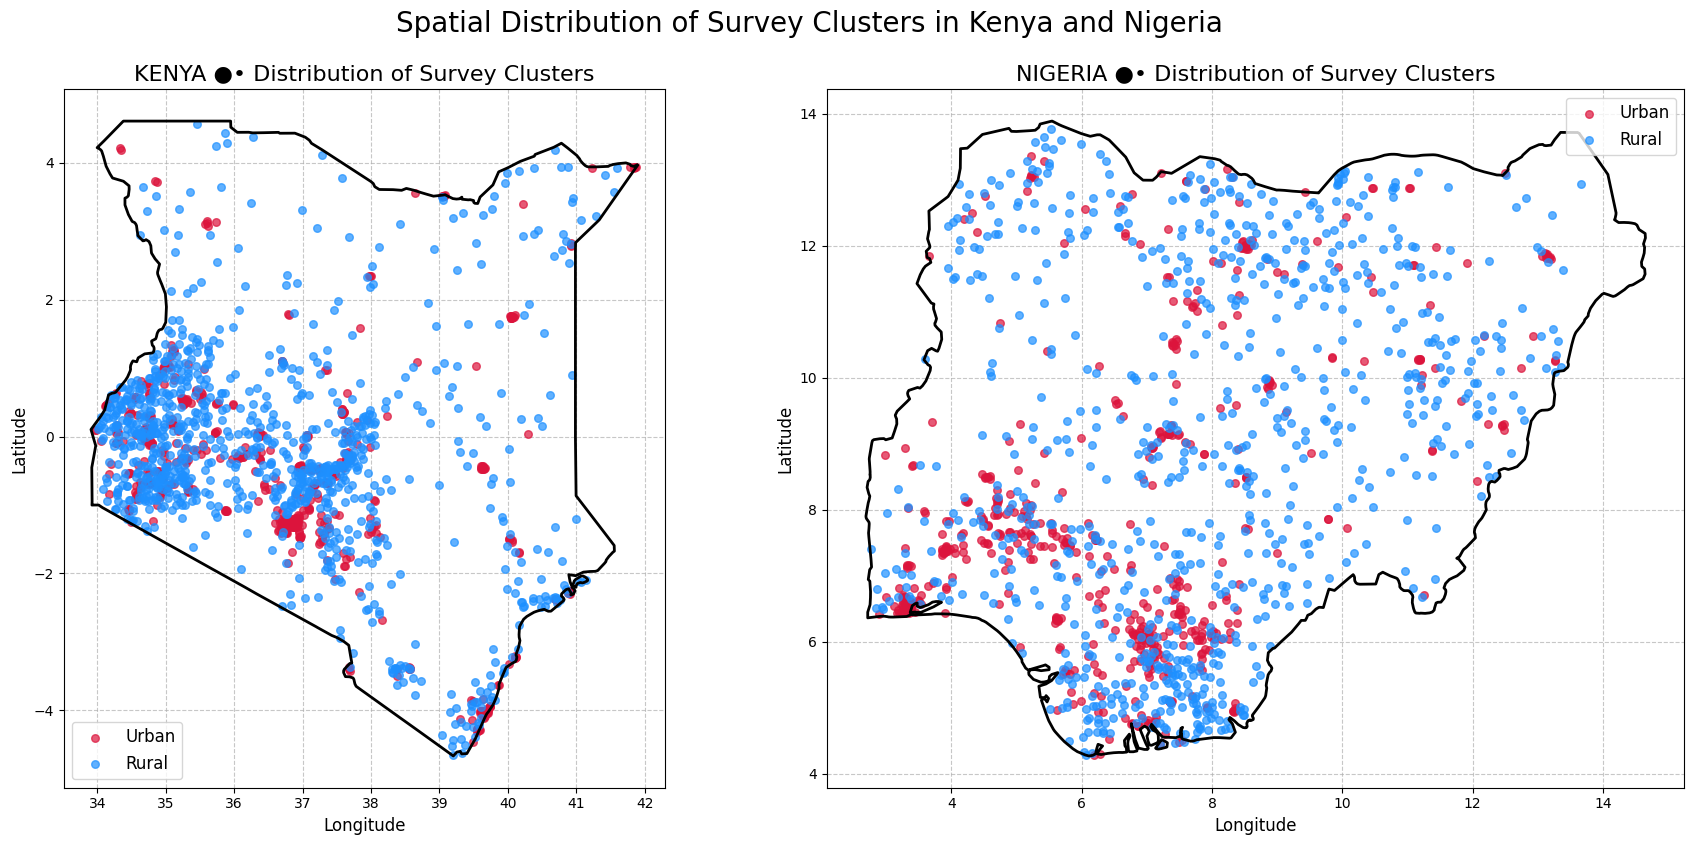

In [15]:
create_cluster_maps()

Question 2.6 ●• Within-Cluster Wealth Variation

In [16]:
# Kenya within-cluster variation
kenya_within_std = kenya_survey.groupby('cluster')['wealth'].std()
kenya_avg_within_std = kenya_within_std.mean()
print(
    f"●• Average within-cluster wealth STD in Kenya --> {kenya_avg_within_std:.4f}")

# Nigeria within-cluster variation
nigeria_within_std = nigeria_survey.groupby('cluster')['wealth'].std()
nigeria_avg_within_std = nigeria_within_std.mean()
print(
    f"●• Average within-cluster wealth STD in Nigeria --> {nigeria_avg_within_std:.4f}")

●• Average within-cluster wealth STD in Kenya --> 49908.6472
●• Average within-cluster wealth STD in Nigeria --> 46964.8082


Question 2.7 ●• Between-Cluster Wealth Variation

In [17]:
kenya_cluster_wealth = kenya_survey.groupby('cluster')['wealth'].mean()
kenya_between_std = kenya_cluster_wealth.std()
print(f"●• Between-cluster wealth std in Kenya --> {kenya_between_std:.4f}")

nigeria_cluster_wealth = nigeria_survey.groupby('cluster')['wealth'].mean()
nigeria_between_std = nigeria_cluster_wealth.std()
print(
    f"●• Between-cluster wealth std in Nigeria --> {nigeria_between_std:.4f}")

●• Between-cluster wealth std in Kenya --> 84455.9763
●• Between-cluster wealth std in Nigeria --> 86946.9952


Question 2.8 ●• Cluster-level Prediction Appropriateness

Based on the standard deviation values, there appears to be more variation between clusters than within clusters in both countries. This suggests that cluster-level predictions are appropriate for capturing the significant socioeconomic differences between geographic areas while providing a reasonable level of aggregation. The between-cluster variation being higher indicates that clusters effectively capture distinct wealth categories.

Part 3 ●• Explore Featurized Satellite Data

In [18]:
kenya_features = pd.read_csv('mosaiks_features_kenya.csv')
nigeria_features = pd.read_csv('mosaiks_features_nigeria.csv')

Question 3.1 ●• MOSAIKS Clusters Count

In [19]:
print(f"●• Kenya clusters with MOSAIKS features --> {len(kenya_features)}")
print(f"●• Nigeria clusters with MOSAIKS features --> {len(nigeria_features)}")

●• Kenya clusters with MOSAIKS features --> 1585
●• Nigeria clusters with MOSAIKS features --> 1382


Question 3.2 ●• MOSAIKS Feature Dimensions

In [20]:
kenya_feature_dim = len(kenya_features.columns) - 1
nigeria_feature_dim = len(nigeria_features.columns) - 1
print(f"●• Kenya MOSAIKS feature dimensions --> {kenya_feature_dim}")
print(f"●• Nigeria MOSAIKS feature dimensions --> {nigeria_feature_dim}")

●• Kenya MOSAIKS feature dimensions --> 499
●• Nigeria MOSAIKS feature dimensions --> 499


Part 4 ●• Train Machine Learning Models

In [21]:
kenya_cluster_avg = kenya_survey.groupby('cluster')['wealth'].mean().reset_index()

kenya_cluster_avg.columns = ['cluster', 'avg_wealth']

nigeria_cluster_avg = nigeria_survey.groupby('cluster')['wealth'].mean().reset_index()
nigeria_cluster_avg.columns = ['cluster', 'avg_wealth']

# Merge with MOSAIKS features
kenya_data = pd.merge(kenya_cluster_avg, kenya_features, on='cluster', how='inner')
nigeria_data = pd.merge(nigeria_cluster_avg, nigeria_features, on='cluster', how='inner')

In [22]:
kenya_X = kenya_data.drop(['cluster', 'avg_wealth'], axis=1)
kenya_y = kenya_data['avg_wealth']

nigeria_X = nigeria_data.drop(['cluster', 'avg_wealth'], axis=1)
nigeria_y = nigeria_data['avg_wealth']

kenya_X_train, kenya_X_test, kenya_y_train, kenya_y_test = train_test_split(kenya_X, kenya_y, test_size=0.25, random_state=0)

nigeria_X_train, nigeria_X_test, nigeria_y_train, nigeria_y_test = train_test_split(nigeria_X, nigeria_y, test_size=0.25, random_state=0)

In [23]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    return train_r2, test_r2

Question 4.1 ●• Kenya Linear Regression

In [24]:
lr_kenya = LinearRegression()
lr_kenya_train_r2, lr_kenya_test_r2 = evaluate_model(
    lr_kenya, kenya_X_train, kenya_X_test, kenya_y_train, kenya_y_test
)
print(f"●• Kenya Linear Regression Training R² --> {lr_kenya_train_r2:.4f}")
print(f"●• Kenya Linear Regression Test R² --> {lr_kenya_test_r2:.4f}")
print(
    f"●• Train-Test R² difference --> {lr_kenya_train_r2 - lr_kenya_test_r2:.4f}")

●• Kenya Linear Regression Training R² --> 0.8488
●• Kenya Linear Regression Test R² --> 0.4085
●• Train-Test R² difference --> 0.4403


In [25]:
overfitting_message = "There is evidence of overfitting as the training R² is significantly higher than test R²" if lr_kenya_train_r2 - \
    lr_kenya_test_r2 > 0.1 else "There is limited evidence of overfitting as the training and test R² values are close"
print(f"●• Overfitting analysis --> {overfitting_message}")

●• Overfitting analysis --> There is evidence of overfitting as the training R² is significantly higher than test R²


Question 4.2 ●• Nigeria Linear Regression

In [26]:
lr_nigeria = LinearRegression()
lr_nigeria_train_r2, lr_nigeria_test_r2 = evaluate_model(
    lr_nigeria, nigeria_X_train, nigeria_X_test, nigeria_y_train, nigeria_y_test
)
print(
    f"●• Nigeria Linear Regression Training R² --> {lr_nigeria_train_r2:.4f}")
print(f"●• Nigeria Linear Regression Test R² --> {lr_nigeria_test_r2:.4f}")
print(
    f"●• Train-Test R² difference --> {lr_nigeria_train_r2 - lr_nigeria_test_r2:.4f}")

●• Nigeria Linear Regression Training R² --> 0.8578
●• Nigeria Linear Regression Test R² --> 0.4119
●• Train-Test R² difference --> 0.4459


In [27]:
overfitting_message = "There is evidence of overfitting as the training R² is significantly higher than test R²" if lr_nigeria_train_r2 - \
    lr_nigeria_test_r2 > 0.1 else "There is limited evidence of overfitting as the training and test R² values are close"
print(f"●• Overfitting analysis --> {overfitting_message}")

●• Overfitting analysis --> There is evidence of overfitting as the training R² is significantly higher than test R²


Question 4.3 ●• Kenya Ridge Regression

In [28]:
alphas = np.logspace(-3, 3, 20)
ridge_cv_kenya = RidgeCV(alphas=alphas, cv=5)
ridge_cv_kenya.fit(kenya_X_train, kenya_y_train)
best_alpha_kenya = ridge_cv_kenya.alpha_

ridge_kenya = Ridge(alpha=best_alpha_kenya)
ridge_kenya_train_r2, ridge_kenya_test_r2 = evaluate_model(
    ridge_kenya, kenya_X_train, kenya_X_test, kenya_y_train, kenya_y_test
)
print(f"●• Kenya Ridge Regression (alpha={best_alpha_kenya:.4f}) Training R² --> {ridge_kenya_train_r2:.4f}")
print(f"●• Kenya Ridge Regression Test R² --> {ridge_kenya_test_r2:.4f}")
print(f"●• Train-Test R² difference --> {ridge_kenya_train_r2 - ridge_kenya_test_r2:.4f}")

ridge_overfitting = "Ridge regression has reduced overfitting compared to linear regression" if (ridge_kenya_train_r2 - ridge_kenya_test_r2) < (lr_kenya_train_r2 - lr_kenya_test_r2) else "There is still evidence of overfitting with Ridge regression"
print(f"●• Ridge regularization effect --> {ridge_overfitting}")

●• Kenya Ridge Regression (alpha=0.0010) Training R² --> 0.7385
●• Kenya Ridge Regression Test R² --> 0.5621
●• Train-Test R² difference --> 0.1764
●• Ridge regularization effect --> Ridge regression has reduced overfitting compared to linear regression


Question 4.4 ●• Nigeria Ridge Regression

In [29]:
ridge_cv_nigeria = RidgeCV(alphas=alphas, cv=5)
ridge_cv_nigeria.fit(nigeria_X_train, nigeria_y_train)
best_alpha_nigeria = ridge_cv_nigeria.alpha_

ridge_nigeria = Ridge(alpha=best_alpha_nigeria)
ridge_nigeria_train_r2, ridge_nigeria_test_r2 = evaluate_model(
    ridge_nigeria, nigeria_X_train, nigeria_X_test, nigeria_y_train, nigeria_y_test
)
print(
    f"●• Nigeria Ridge Regression (alpha={best_alpha_nigeria:.4f}) Training R² --> {ridge_nigeria_train_r2:.4f}")
print(f"●• Nigeria Ridge Regression Test R² --> {ridge_nigeria_test_r2:.4f}")
print(
    f"●• Train-Test R² difference --> {ridge_nigeria_train_r2 - ridge_nigeria_test_r2:.4f}")

●• Nigeria Ridge Regression (alpha=0.0010) Training R² --> 0.7544
●• Nigeria Ridge Regression Test R² --> 0.6790
●• Train-Test R² difference --> 0.0754


In [30]:

ridge_overfitting = "Ridge regression has reduced overfitting compared to linear regression" if (
    ridge_nigeria_train_r2 - ridge_nigeria_test_r2) < (lr_nigeria_train_r2 - lr_nigeria_test_r2) else "There is still evidence of overfitting with Ridge regression"
print(f"●• Ridge regularization effect --> {ridge_overfitting}")

●• Ridge regularization effect --> Ridge regression has reduced overfitting compared to linear regression


Question 4.5 ●• Kenya Random Forest

In [31]:
max_depths = range(2, 21)
kenya_rf_results = []

for depth in max_depths:
    rf_kenya = RandomForestRegressor(max_depth=depth, random_state=0)
    rf_kenya_train_r2, rf_kenya_test_r2 = evaluate_model(
        rf_kenya, kenya_X_train, kenya_X_test, kenya_y_train, kenya_y_test
    )
    kenya_rf_results.append((depth, rf_kenya_train_r2, rf_kenya_test_r2))

kenya_rf_df = pd.DataFrame(kenya_rf_results, columns=[
                           'max_depth', 'train_r2', 'test_r2'])
best_depth_kenya = kenya_rf_df.loc[kenya_rf_df['test_r2'].idxmax(
)]['max_depth']
best_test_r2_kenya = kenya_rf_df['test_r2'].max()

print(f"●• Best max_depth for Kenya Random Forest --> {best_depth_kenya:.0f}")
print(f"●• Best Kenya RF Test R² --> {best_test_r2_kenya:.4f}")

●• Best max_depth for Kenya Random Forest --> 20
●• Best Kenya RF Test R² --> 0.4470


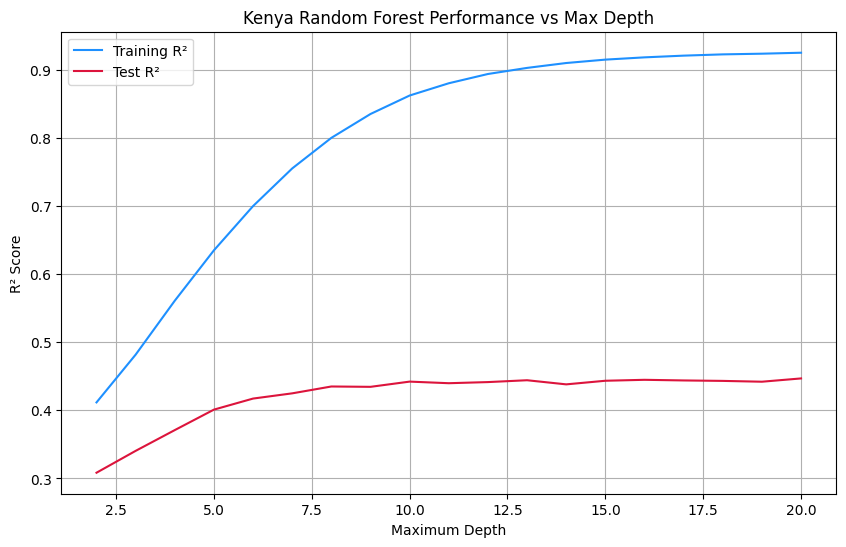

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(kenya_rf_df['max_depth'],
         kenya_rf_df['train_r2'], label='Training R²', color='dodgerblue')
plt.plot(kenya_rf_df['max_depth'],
         kenya_rf_df['test_r2'], label='Test R²', color='crimson')
plt.xlabel('Maximum Depth')
plt.ylabel('R² Score')
plt.title('Kenya Random Forest Performance vs Max Depth')
plt.legend()
plt.grid(True)
plt.savefig('kenya_rf_performance.png')
plt.show()
plt.close()

Question 4.6 ●• Nigeria Random Forest

In [33]:
nigeria_rf_results = []

for depth in max_depths:
    rf_nigeria = RandomForestRegressor(max_depth=depth, random_state=0)
    rf_nigeria_train_r2, rf_nigeria_test_r2 = evaluate_model(
        rf_nigeria, nigeria_X_train, nigeria_X_test, nigeria_y_train, nigeria_y_test
    )
    nigeria_rf_results.append((depth, rf_nigeria_train_r2, rf_nigeria_test_r2))

# Convert results to DataFrame
nigeria_rf_df = pd.DataFrame(nigeria_rf_results, columns=[
                             'max_depth', 'train_r2', 'test_r2'])
best_depth_nigeria = nigeria_rf_df.loc[nigeria_rf_df['test_r2'].idxmax(
)]['max_depth']
best_test_r2_nigeria = nigeria_rf_df['test_r2'].max()

print(
    f"●• Best max_depth for Nigeria Random Forest --> {best_depth_nigeria:.0f}")
print(f"●• Best Nigeria RF Test R² --> {best_test_r2_nigeria:.4f}")

●• Best max_depth for Nigeria Random Forest --> 14
●• Best Nigeria RF Test R² --> 0.6386


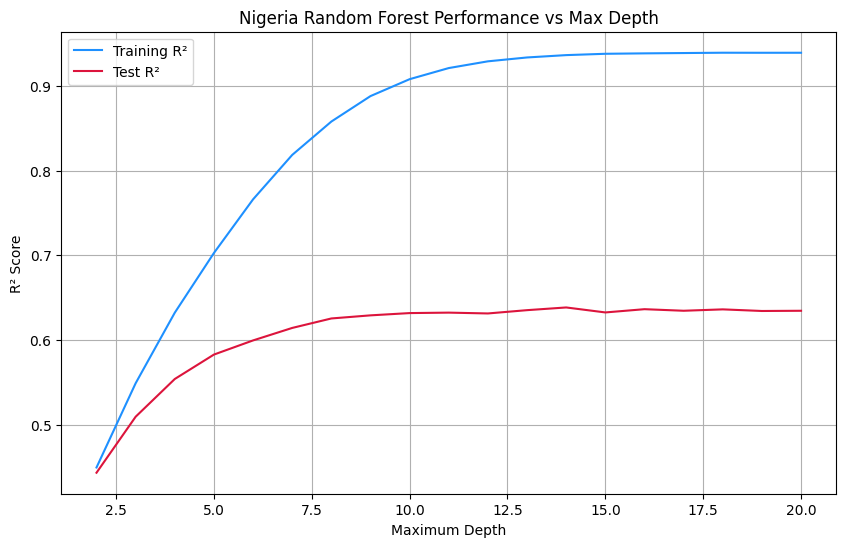

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(nigeria_rf_df['max_depth'],
         nigeria_rf_df['train_r2'], label='Training R²', color='dodgerblue')
plt.plot(nigeria_rf_df['max_depth'],
         nigeria_rf_df['test_r2'], label='Test R²', color='crimson')
plt.xlabel('Maximum Depth')
plt.ylabel('R² Score')
plt.title('Nigeria Random Forest Performance vs Max Depth')
plt.legend()
plt.grid(True)
plt.savefig('nigeria_rf_performance.png')
plt.show()
plt.close()

Part 5: Out-of-Distribution Predictions

In [35]:
kenya_cluster_rural = kenya_survey[['cluster', 'rural']].drop_duplicates()
kenya_cluster_map = dict(
    zip(kenya_cluster_rural['cluster'], kenya_cluster_rural['rural']))

kenya_data['rural'] = kenya_data['cluster'].map(kenya_cluster_map)
kenya_X_rural = kenya_data[kenya_data['rural'] == 1].drop(
    ['cluster', 'avg_wealth', 'rural'], axis=1)
kenya_y_rural = kenya_data[kenya_data['rural'] == 1]['avg_wealth']
kenya_X_urban = kenya_data[kenya_data['rural'] == 0].drop(
    ['cluster', 'avg_wealth', 'rural'], axis=1)
kenya_y_urban = kenya_data[kenya_data['rural'] == 0]['avg_wealth']

# Split train/test sets for rural and urban separately
kenya_rural_X_train, kenya_rural_X_test, kenya_rural_y_train, kenya_rural_y_test = train_test_split(
    kenya_X_rural, kenya_y_rural, test_size=0.25, random_state=0
)

kenya_urban_X_train, kenya_urban_X_test, kenya_urban_y_train, kenya_urban_y_test = train_test_split(
    kenya_X_urban, kenya_y_urban, test_size=0.25, random_state=0
)

Question 5.1 ●• Urban-Trained Model Performance

In [36]:
ridge_cv_urban = RidgeCV(alphas=alphas, cv=5)
ridge_cv_urban.fit(kenya_urban_X_train, kenya_urban_y_train)
urban_model = Ridge(alpha=ridge_cv_urban.alpha_)
urban_model.fit(kenya_urban_X_train, kenya_urban_y_train)

# Test on both urban and rural test sets
urban_pred_urban = urban_model.predict(kenya_urban_X_test)
urban_pred_rural = urban_model.predict(kenya_rural_X_test)

urban_urban_r2 = r2_score(kenya_urban_y_test, urban_pred_urban)
urban_rural_r2 = r2_score(kenya_rural_y_test, urban_pred_rural)

print(f"●• Urban-trained model on urban test data R² --> {urban_urban_r2:.4f}")
print(f"●• Urban-trained model on rural test data R² --> {urban_rural_r2:.4f}")

urban_rural_gap = urban_urban_r2 - urban_rural_r2
generalization_msg = f"The urban-trained model shows {'poor' if urban_rural_gap > 0.2 else 'reasonable'} generalization to rural areas with an R² difference of {urban_rural_gap:.4f}. This suggests that wealth indicators in urban satellite imagery {'differ significantly from' if urban_rural_gap > 0.2 else 'have some similarity to'} those in rural areas."
print(f"●• Generalization analysis --> {generalization_msg}")

●• Urban-trained model on urban test data R² --> 0.3608
●• Urban-trained model on rural test data R² --> -0.9382
●• Generalization analysis --> The urban-trained model shows poor generalization to rural areas with an R² difference of 1.2991. This suggests that wealth indicators in urban satellite imagery differ significantly from those in rural areas.


Question 5.2 ●• Rural-Trained Model Performance

In [37]:
ridge_cv_rural = RidgeCV(alphas=alphas, cv=5)
ridge_cv_rural.fit(kenya_rural_X_train, kenya_rural_y_train)
rural_model = Ridge(alpha=ridge_cv_rural.alpha_)
rural_model.fit(kenya_rural_X_train, kenya_rural_y_train)

# Test on both rural and urban test sets
rural_pred_rural = rural_model.predict(kenya_rural_X_test)
rural_pred_urban = rural_model.predict(kenya_urban_X_test)

rural_rural_r2 = r2_score(kenya_rural_y_test, rural_pred_rural)
rural_urban_r2 = r2_score(kenya_urban_y_test, rural_pred_urban)

print(f"●• Rural-trained model on rural test data R² --> {rural_rural_r2:.4f}")
print(f"●• Rural-trained model on urban test data R² --> {rural_urban_r2:.4f}")

rural_urban_gap = rural_rural_r2 - rural_urban_r2
generalization_msg = f"The rural-trained model shows {'poor' if rural_urban_gap > 0.2 else 'reasonable'} generalization to urban areas with an R² difference of {rural_urban_gap:.4f}. This suggests that wealth indicators in rural satellite imagery {'differ significantly from' if rural_urban_gap > 0.2 else 'have some similarity to'} those in urban areas."
print(f"●• Generalization analysis --> {generalization_msg}")

●• Rural-trained model on rural test data R² --> 0.6054
●• Rural-trained model on urban test data R² --> -0.4125
●• Generalization analysis --> The rural-trained model shows poor generalization to urban areas with an R² difference of 1.0178. This suggests that wealth indicators in rural satellite imagery differ significantly from those in urban areas.


Question 5.4 ●• Kenya Model on Nigeria Data

In [38]:
kenya_to_nigeria_model = RidgeCV(alphas=alphas, cv=5)
kenya_to_nigeria_model.fit(kenya_X_train, kenya_y_train)
kenya_nigeria_preds = kenya_to_nigeria_model.predict(nigeria_X_test)
kenya_to_nigeria_r2 = r2_score(nigeria_y_test, kenya_nigeria_preds)

print(f"●• Kenya model on Kenya test data R² --> {ridge_kenya_test_r2:.4f}")
print(f"●• Kenya model on Nigeria test data R² --> {kenya_to_nigeria_r2:.4f}")

cross_country_msg = f"The Kenya model's performance drops by {ridge_kenya_test_r2 - kenya_to_nigeria_r2:.4f} when applied to Nigeria, indicating {'poor' if ridge_kenya_test_r2 - kenya_to_nigeria_r2 > 0.3 else 'moderate'} cross-country generalization. This suggests significant differences in how wealth manifests visually in satellite imagery between the two countries."
print(f"●• Cross-country generalization --> {cross_country_msg}")

●• Kenya model on Kenya test data R² --> 0.5621
●• Kenya model on Nigeria test data R² --> 0.1974
●• Cross-country generalization --> The Kenya model's performance drops by 0.3647 when applied to Nigeria, indicating poor cross-country generalization. This suggests significant differences in how wealth manifests visually in satellite imagery between the two countries.


Question 5.5 ●• Nigeria Model on Kenya Data

In [39]:
nigeria_to_kenya_model = RidgeCV(alphas=alphas, cv=5)
nigeria_to_kenya_model.fit(nigeria_X_train, nigeria_y_train)
nigeria_kenya_preds = nigeria_to_kenya_model.predict(kenya_X_test)
nigeria_to_kenya_r2 = r2_score(kenya_y_test, nigeria_kenya_preds)

print(f"●• Nigeria model on Nigeria test data R² --> {ridge_nigeria_test_r2:.4f}")
print(f"●• Nigeria model on Kenya test data R² --> {nigeria_to_kenya_r2:.4f}")

cross_country_msg = f"The Nigeria model's performance drops by {ridge_nigeria_test_r2 - nigeria_to_kenya_r2:.4f} when applied to Kenya, indicating {'poor' if ridge_nigeria_test_r2 - nigeria_to_kenya_r2 > 0.3 else 'moderate'} cross-country generalization. This bidirectional testing confirms that satellite-based poverty prediction models are highly context-specific and require local calibration."
print(f"●• Cross-country generalization --> {cross_country_msg}")

●• Nigeria model on Nigeria test data R² --> 0.6790
●• Nigeria model on Kenya test data R² --> -0.1682
●• Cross-country generalization --> The Nigeria model's performance drops by 0.8472 when applied to Kenya, indicating poor cross-country generalization. This bidirectional testing confirms that satellite-based poverty prediction models are highly context-specific and require local calibration.



<center>

$\text{\textcolor{cyan}{⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝}}$

### **$\text{Part 6 ●• Synthesis and Reflection}$**

$\text{\textcolor{cyan}{⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝}}$

</center>
